# Coursework A
Implementation of kNN and cross-validation - the codes are as low-level as possible.  


In [2]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

iris = datasets.load_iris()

## 1. Exploratory Data Analysis

In [3]:
def myplotGrid(X,y):
    fig = plt.figure(figsize=(8,8))
    labels=['sepal length', 'sepal width', 'petal length', 'petal width']
    count=1
    for i in range(0,4):
        for j in range (0,4):
            ax = fig.add_subplot(4,4,count) #
            if(i==j):
                plt.hist(X[:,i])
            else:
                plt.scatter(X[:, i], X[:, j], c=y, cmap=plt.cm.Paired)
            if(i==3):
                plt.xlabel(labels[i])
            if(j==0):
                plt.ylabel(labels[j])        
            count+=1


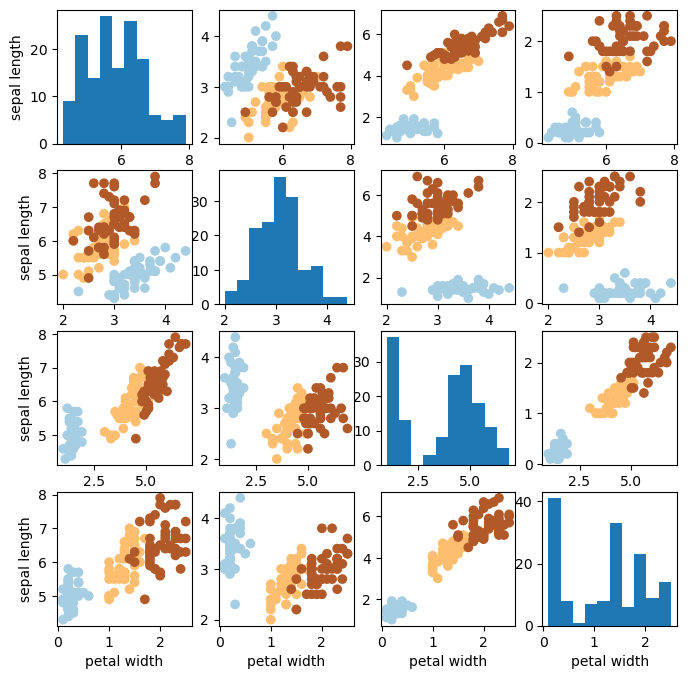

In [4]:
X = iris.data
Y = iris.target
myplotGrid(X,Y)

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings (e.g., from webcams or other errors) they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Perturb our data with some Gaussian noise, to si
    


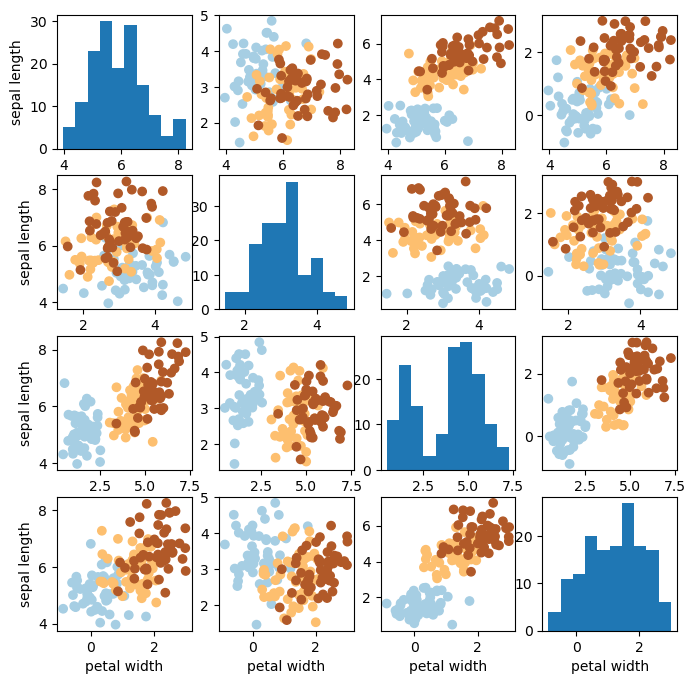

In [4]:
mySeed=1234567

np.random.seed(mySeed)
XN = X + np.random.normal(0,0.5,X.shape)
myplotGrid(XN,Y)

## 2. Implementing kNN

In the cell below, develop your own code for performing k-Nearest Neighbour classification.  You are guided to do this by following the notebook accompanying the coursework.  Define a function that performs k-NN given a set of data.  Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

**Note:** if you need help implementing k-NN, you can use Nested Cross-Validation.ipynb

In [184]:
def getNeighbours(x_, X, n, T,default = 'euclidean'):
    distances = np.zeros(T)
    if default == 'euclidean':
        distances[:] = np.linalg.norm(X[:]-x_,axis = 1,ord=2)
        
    elif default == 'manhattan':
        distances[:] = np.linalg.norm(X[:]-x_,axis = 1, ord= 1)
    
    elif default == 'chebychev':
        distances[:] = np.linalg.norm(X[:]-x_,axis = 1, ord= np.inf)
        
    idx = np.argsort(distances)
    return idx[:n]

In [185]:
def assignLabel(nLabels):
    if len(nLabels) == 1: 
        return nLabels[0]
    else:
        Label, nLabel = np.unique(nLabels, return_counts=True) 
        Idx = np.argmax(nLabel) 
        majLabel = Label[Idx] 
        return majLabel

In [186]:
def assignLabelweight(nLabels, distances):
    if len(nLabels) == 1: 
        return nLabels[0]
    else:
        Label, nLabel = np.unique(nLabels, return_counts=True) 
        weightedFreq = np.zeros(len(Label))
        for i, label in enumerate(Label):
            idx = np.where(nLabels == label)[0]
            weightedFreq[i] = np.sum(1 / (distances[idx]))
        Idx = np.argmax(weightedFreq) 
        weightedLabel = Label[Idx] 
        return weightedLabel

In [187]:
def mykNN(X, y,foldTrain,foldTest, k, default='euclidean', weighted=False):
    correct = 0
    y__ = np.zeros(len(y)) #predicted labels
    for i in foldTest:
        # knn classifier
        x_ = X[i] # test point x_
        y_ = y[i] # true label for y_

        # get neighbours of x_ in training data
        neighbours = getNeighbours(x_, X[foldTrain], k, len(foldTrain), default=default)
        if weighted:
            distances = np.linalg.norm(X[foldTrain][neighbours]-x_,axis = 1,ord=2)
            y__[i] = assignLabelweight(y[foldTrain[neighbours]], distances)
        else:
            y__[i] = assignLabel(y[foldTrain[neighbours]])
            
        if y__[i] == y_:
            correct += 1

    accuracy = correct / len(foldTest)
    return y__, accuracy

* Clean Data

In [188]:
np.random.seed(1234567)
indices= np.random.permutation(X.shape[0]) 
bins=np.array_split(indices,2) # we  just need a training and testing set here
foldTrain=bins[0]
foldTest=bins[1]

In [194]:
y_,accuracy = mykNN(X,Y,foldTrain,foldTest,10,'euclidean',weighted = False)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 97.33%


* Noisy Data

In [190]:
np.random.seed(1234567)
indices= np.random.permutation(XN.shape[0]) 
bins=np.array_split(indices,2) # we  just need a training and testing set here
foldTrain=bins[0]
foldTest=bins[1]

In [193]:
y_,accuracy = mykNN(XN,Y,foldTrain,foldTest,10,'euclidean',weighted = False)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 88.00%


## 3. Nested Cross-validation using your implementation of KNN

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above.  Again, you are guided to complete this task by following the appropriate notebook accompanying this coursework.  Your code for nested cross-validation should invoke your kNN function (see above).  You cross validation function should be invoked similary to:

    accuracy_fold=myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan']`` evaluates the two distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.

**Notes:** 
- you should perform nested cross-validation on both your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should implement/validate at least three distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each fold, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)
 
**Note:** if you need help implementing cv, you can use nested cross-validation.ipynb


* A function for printing confusion matrices, i just used a visualisation tool from sklearn the calculations are created from scratch . 

In [100]:
def confusion_matrix3(x_true,x_predicted):
    t0,t1,t2,f01,f02,f10,f12,f20,f21 = 0,0,0,0,0,0,0,0,0
    
    for actual_value, predicted_value in zip(x_true, x_predicted):
        if predicted_value == actual_value: # t?
            if predicted_value == 0: # tp
                t0 += 1
            elif predicted_value == 1: # tn
                t1 += 1
            else:
                t2 +=1
        elif predicted_value == 0 and actual_value == 1:
            f01 +=1
        elif predicted_value == 1 and actual_value == 0:
            f10 +=1
        elif predicted_value == 2 and actual_value == 0:
            f20 +=1
        elif predicted_value == 2 and actual_value == 1:
            f21 +=1
        elif predicted_value == 0 and actual_value == 2:
            f02 +=1
        elif predicted_value == 1 and actual_value == 2:
            f12 +=1 
            
        confusion_matrix = [
            [t0,  f10,  f20],
            [f01, t1,  f21],
            [f02, f12, t2] ]

        confusion_matrix = np.array(confusion_matrix)
    
    return confusion_matrix

In [138]:
from sklearn import metrics

def myNestedCrossVal(X,y,foldK,nns,dists,mySeed):
    np.random.seed(mySeed)
    accuracy_fold=[]
    
    indices = np.random.permutation(len(X))
    
    bins = np.array_split(indices, foldK)
    
    total_matrix = np.zeros((3,3)) #just saving the total confusing matrix
    
    assert(foldK==len(bins))
    
    #loop through folds
    for i in range(0,foldK):
        foldTrain=[]
        foldTest=[]  
        foldVal=[]    

        #loop through all bins, take bin i for testing, the next bin for validation and the rest for training
        for j in range(0,len(bins)):
            if j == i:
                foldTest = bins[j].tolist()
            elif j == (i+1) % foldK:
                foldVal = bins[j].tolist()
            else:
                foldTrain+=bins[j].tolist()
                
        
        foldTrain = np.array(foldTrain)
        foldTest = np.array(foldTest)
        foldVal = np.array(foldVal)
        
        bestDistance='' #save the best distance metric here
        bestNN=-1 #save the best number of neighbours here
        bestAccuracy=-10 #save the best attained accuracy here (in terms of validation)
        
        print(f"Results and parameters for test fold number {i}")
        print("----------------------------------------------")
        for dist in dists:
            for nn in nns:
                y_,accuracy = mykNN(X, y, foldTrain, foldVal, nn, dist)
                
                print(f' nn = {nn}  Distance = {dist} Accuracy = {accuracy}')
                if accuracy > bestAccuracy:
                    bestDistance = dist
                    bestNN = nn
                    bestAccuracy = accuracy
            
        print(f'**End of val for this fold, best nn = {bestNN}, best distance = {bestDistance}**')
        
        y_pred, accuracy = mykNN(X, y, np.concatenate((foldTrain,foldVal)), foldTest, bestNN, bestDistance)
        accuracy_fold.append(accuracy)

        print(f'==== Final Cross-val on test on this fold with NN {bestNN} distance {bestDistance} accuracy = {accuracy_fold[i]} error = {1-accuracy_fold[i]}  \n')
        
        confusion_matrix = confusion_matrix3(y[foldTest], y_pred[foldTest])
        
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1,2])

        cm_display.plot()
        plt.title(f"fold no.{i}")
        plt.savefig(f'confusion_fold{i}.png', format='png', dpi=300)
        plt.show()
        
        
        total_matrix += confusion_matrix
        
    return accuracy_fold,total_matrix;
    



### Clean Data

Results and parameters for test fold number 0
----------------------------------------------
 nn = 1  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 2  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 3  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 4  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 5  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 6  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 7  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 8  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 9  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 10  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 1  Distance = manhattan Accuracy = 0.9333333333333333
 nn = 2  Distance = manhattan Accuracy = 0.9
 nn = 3  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 4  Distance = manhattan Accuracy = 0.9333333333333333
 nn = 5  Distance = manhattan Accuracy = 0.9333333333333333
 nn = 6  Distance = m

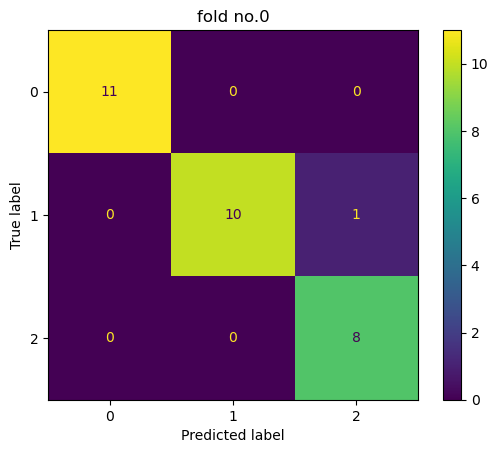

Results and parameters for test fold number 1
----------------------------------------------
 nn = 1  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 2  Distance = euclidean Accuracy = 0.9
 nn = 3  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 4  Distance = euclidean Accuracy = 1.0
 nn = 5  Distance = euclidean Accuracy = 1.0
 nn = 6  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 7  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 8  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 9  Distance = euclidean Accuracy = 1.0
 nn = 10  Distance = euclidean Accuracy = 1.0
 nn = 1  Distance = manhattan Accuracy = 0.9
 nn = 2  Distance = manhattan Accuracy = 0.8666666666666667
 nn = 3  Distance = manhattan Accuracy = 1.0
 nn = 4  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 5  Distance = manhattan Accuracy = 0.9333333333333333
 nn = 6  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 7  Distance = manhattan Accuracy = 0.93333333

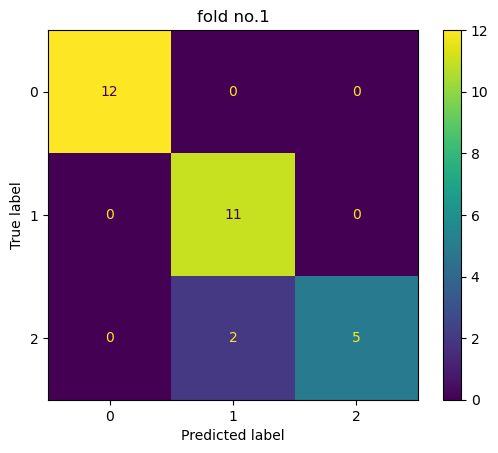

Results and parameters for test fold number 2
----------------------------------------------
 nn = 1  Distance = euclidean Accuracy = 1.0
 nn = 2  Distance = euclidean Accuracy = 1.0
 nn = 3  Distance = euclidean Accuracy = 1.0
 nn = 4  Distance = euclidean Accuracy = 1.0
 nn = 5  Distance = euclidean Accuracy = 1.0
 nn = 6  Distance = euclidean Accuracy = 1.0
 nn = 7  Distance = euclidean Accuracy = 1.0
 nn = 8  Distance = euclidean Accuracy = 1.0
 nn = 9  Distance = euclidean Accuracy = 1.0
 nn = 10  Distance = euclidean Accuracy = 1.0
 nn = 1  Distance = manhattan Accuracy = 1.0
 nn = 2  Distance = manhattan Accuracy = 1.0
 nn = 3  Distance = manhattan Accuracy = 1.0
 nn = 4  Distance = manhattan Accuracy = 1.0
 nn = 5  Distance = manhattan Accuracy = 1.0
 nn = 6  Distance = manhattan Accuracy = 1.0
 nn = 7  Distance = manhattan Accuracy = 1.0
 nn = 8  Distance = manhattan Accuracy = 1.0
 nn = 9  Distance = manhattan Accuracy = 1.0
 nn = 10  Distance = manhattan Accuracy = 1.0
 nn =

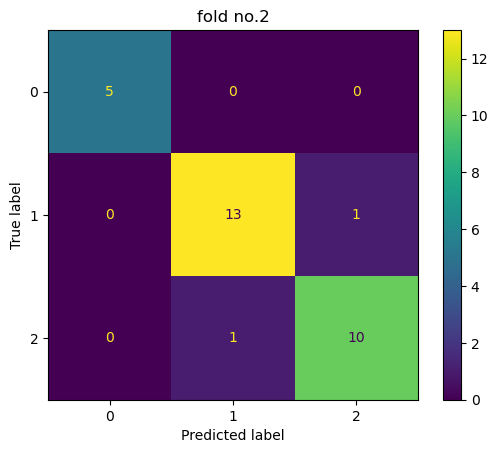

Results and parameters for test fold number 3
----------------------------------------------
 nn = 1  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 2  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 3  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 4  Distance = euclidean Accuracy = 1.0
 nn = 5  Distance = euclidean Accuracy = 1.0
 nn = 6  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 7  Distance = euclidean Accuracy = 1.0
 nn = 8  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 9  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 10  Distance = euclidean Accuracy = 1.0
 nn = 1  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 2  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 3  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 4  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 5  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 6  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 

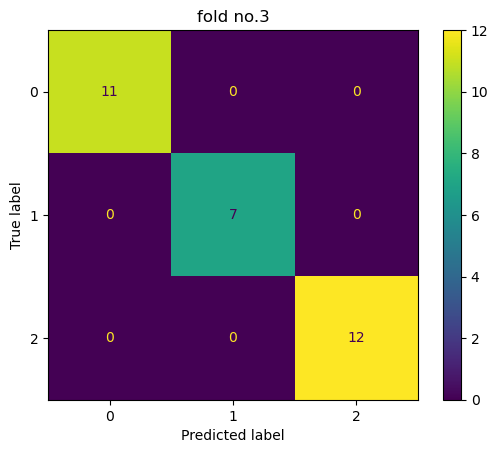

Results and parameters for test fold number 4
----------------------------------------------
 nn = 1  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 2  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 3  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 4  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 5  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 6  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 7  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 8  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 9  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 10  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 1  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 2  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 3  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 4  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 5  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 

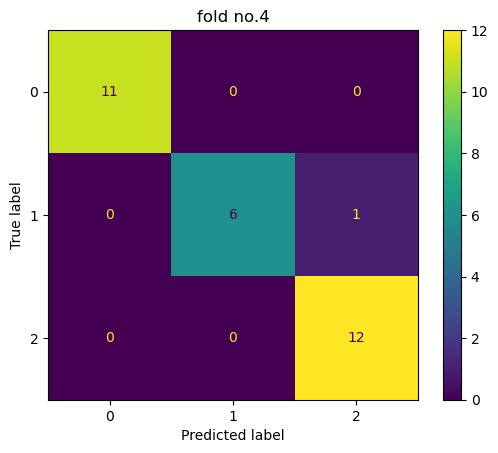

accuracy per fold is :[0.9666666666666667, 0.9333333333333333, 0.9333333333333333, 1.0, 0.9666666666666667] 
 av_accuracy = 0.96 +/- 0.02


In [139]:
accuracy_fold,confusion_matrix=myNestedCrossVal(X,Y,5,list(range(1,11)),['euclidean','manhattan','chebychev'],mySeed)
print(f'accuracy per fold is :{accuracy_fold} \n av_accuracy = {np.mean(accuracy_fold):.2f} +/- {np.std(accuracy_fold):.2f}')

#### Total confusion matrix (clean data)

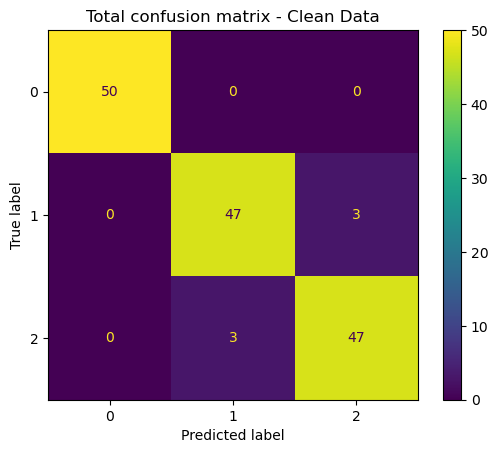

In [140]:

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1,2])

cm_display.plot()
plt.title(f"Total confusion matrix - Clean Data")
plt.savefig(f'confusion_fold_total_clean.png', format='png', dpi=300)
plt.show()

### Noisy Data

Results and parameters for test fold number 0
----------------------------------------------
 nn = 1  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 2  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 3  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 4  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 5  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 6  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 7  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 8  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 9  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 10  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 1  Distance = manhattan Accuracy = 0.8333333333333334
 nn = 2  Distance = manhattan Accuracy = 0.8666666666666667
 nn = 3  Distance = manhattan Accuracy = 0.8333333333333334
 nn = 4  Distance = manhattan Accuracy = 0.8666666666666667
 nn = 5  Distance = manhattan Accuracy = 0.8666666666666667
 nn = 

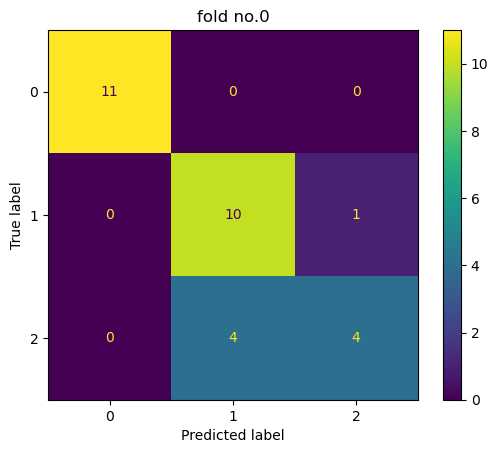

Results and parameters for test fold number 1
----------------------------------------------
 nn = 1  Distance = euclidean Accuracy = 0.8
 nn = 2  Distance = euclidean Accuracy = 0.8
 nn = 3  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 4  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 5  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 6  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 7  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 8  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 9  Distance = euclidean Accuracy = 0.9
 nn = 10  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 1  Distance = manhattan Accuracy = 0.8
 nn = 2  Distance = manhattan Accuracy = 0.8
 nn = 3  Distance = manhattan Accuracy = 0.8
 nn = 4  Distance = manhattan Accuracy = 0.8333333333333334
 nn = 5  Distance = manhattan Accuracy = 0.8666666666666667
 nn = 6  Distance = manhattan Accuracy = 0.8333333333333334
 nn = 7  Distance = manhattan Accura

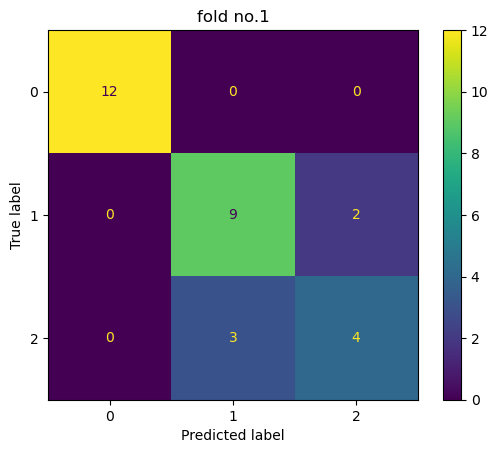

Results and parameters for test fold number 2
----------------------------------------------
 nn = 1  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 2  Distance = euclidean Accuracy = 1.0
 nn = 3  Distance = euclidean Accuracy = 0.9333333333333333
 nn = 4  Distance = euclidean Accuracy = 1.0
 nn = 5  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 6  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 7  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 8  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 9  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 10  Distance = euclidean Accuracy = 0.9666666666666667
 nn = 1  Distance = manhattan Accuracy = 0.9
 nn = 2  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 3  Distance = manhattan Accuracy = 0.9333333333333333
 nn = 4  Distance = manhattan Accuracy = 0.9333333333333333
 nn = 5  Distance = manhattan Accuracy = 0.9666666666666667
 nn = 6  Distance = manhattan Accuracy = 0.93333333

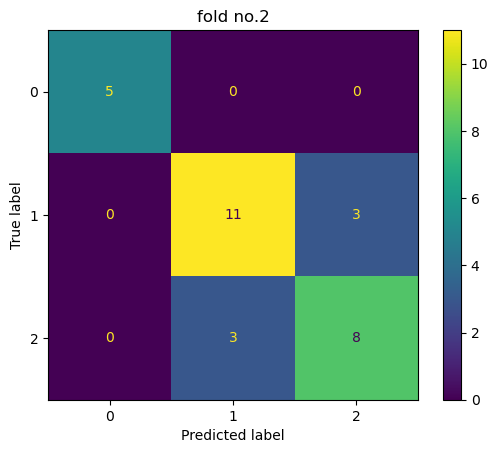

Results and parameters for test fold number 3
----------------------------------------------
 nn = 1  Distance = euclidean Accuracy = 0.7333333333333333
 nn = 2  Distance = euclidean Accuracy = 0.7666666666666667
 nn = 3  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 4  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 5  Distance = euclidean Accuracy = 0.9
 nn = 6  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 7  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 8  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 9  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 10  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 1  Distance = manhattan Accuracy = 0.7
 nn = 2  Distance = manhattan Accuracy = 0.8
 nn = 3  Distance = manhattan Accuracy = 0.8333333333333334
 nn = 4  Distance = manhattan Accuracy = 0.8333333333333334
 nn = 5  Distance = manhattan Accuracy = 0.8666666666666667
 nn = 6  Distance = manhattan Accuracy = 0.83333333

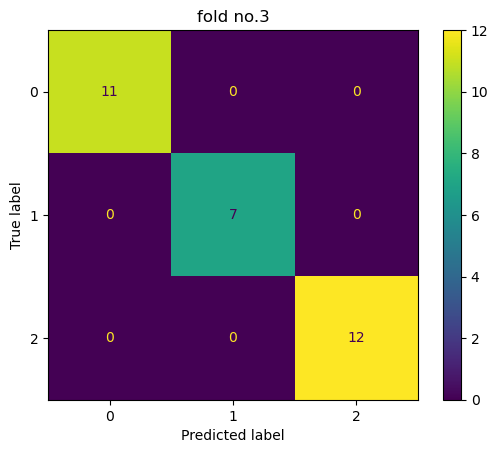

Results and parameters for test fold number 4
----------------------------------------------
 nn = 1  Distance = euclidean Accuracy = 0.7666666666666667
 nn = 2  Distance = euclidean Accuracy = 0.8
 nn = 3  Distance = euclidean Accuracy = 0.8
 nn = 4  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 5  Distance = euclidean Accuracy = 0.8333333333333334
 nn = 6  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 7  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 8  Distance = euclidean Accuracy = 0.9
 nn = 9  Distance = euclidean Accuracy = 0.8666666666666667
 nn = 10  Distance = euclidean Accuracy = 0.9
 nn = 1  Distance = manhattan Accuracy = 0.7333333333333333
 nn = 2  Distance = manhattan Accuracy = 0.8333333333333334
 nn = 3  Distance = manhattan Accuracy = 0.8333333333333334
 nn = 4  Distance = manhattan Accuracy = 0.8333333333333334
 nn = 5  Distance = manhattan Accuracy = 0.8333333333333334
 nn = 6  Distance = manhattan Accuracy = 0.9
 nn = 7  Distance = m

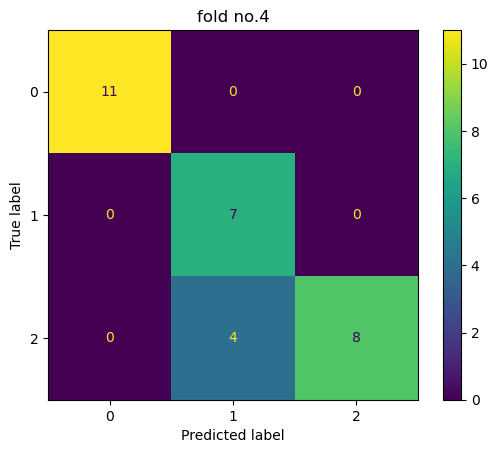

accuracy per fold is :[0.8333333333333334, 0.8333333333333334, 0.8, 1.0, 0.8666666666666667] 
 av_accuracy = 0.87 +/- 0.07


In [147]:
accuracy_fold,confusion_matrix=myNestedCrossVal(XN,Y,5,list(range(1,11)),['euclidean','manhattan','chebychev'],mySeed)
print(f'accuracy per fold is :{accuracy_fold} \n av_accuracy = {np.mean(accuracy_fold):.2f} +/- {np.std(accuracy_fold):.2f}')

#### Total confusion matrix (Dirty data)

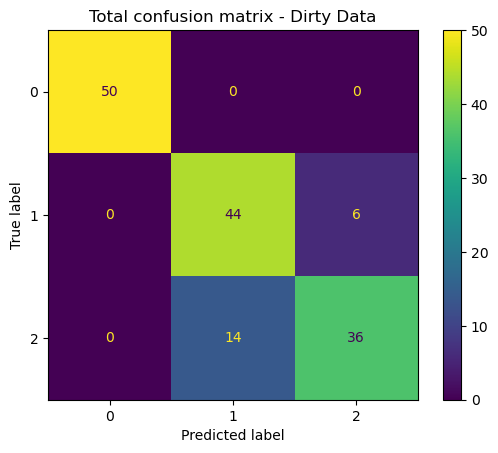

In [144]:

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1,2])

cm_display.plot()
plt.title(f"Total confusion matrix - Dirty Data")
plt.savefig(f'confusion_fold_total_dirty.png', format='png', dpi=300)
plt.show()